# In here I will implement the VGG16 model with all the 2D data which are ['stft_db', 'chroma', 'mfccs'] I will turn them all into (224,224,3)

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import torch
# Import libraries
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16


In [22]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [23]:

genre_names = ['rock', 'pop', 'arabesk', 'turk_sanat', 'jazz', 'rap']

# Load the features.pkl file
with open('../../data/features.pkl', 'rb') as file:
    all_features = pickle.load(file)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features)

# Display the DataFrame (optional)
print(df.shape)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000219BA572B90>>
Traceback (most recent call last):
  File "c:\Users\PC\Documents\GitHub\CS464_ML_Project\venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


(637, 9)


In [4]:
column_names = list(df.columns)
print(column_names)
print(df['stft_db'][0].shape)

['stft_db', 'spectral_rolloff', 'zcr', 'chroma', 'mfccs', 'rms', 'spectral_centroid', 'file_name', 'label']
(1025, 1280)


In [10]:
# Function to process a single feature (e.g., STFT, Chroma, MFCC)
def preprocess_feature(feature_data):
    resized = torch.nn.functional.interpolate(
        torch.tensor(feature_data).unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0)
    
    # Normalize to 0-1 range
    normalized = (resized - resized.min()) / (resized.max() - resized.min())
    
    return normalized

# Convert all features and combine them into a single 3-channel input
processed_features = []
for _, row in df.iterrows():
    stft = preprocess_feature(row['stft_db'])  # Shape: (224, 224)
    chroma = preprocess_feature(row['chroma'])  # Shape: (224, 224)
    mfccs = preprocess_feature(row['mfccs'])  # Shape: (224, 224)

    # Stack them into (3, 224, 224) and permute to (224, 224, 3)
    combined = torch.stack([stft, chroma, mfccs], dim=0).permute(1, 2, 0)
    
    processed_features.append(combined)  # Convert to NumPy for later use


y = to_categorical(df['label'].values, num_classes=len(genre_names))

In [11]:
# Convert to tensor
X = np.array(processed_features)  # Shape: (num_samples, 224, 224, 3)
print("Processed data shape:", X.shape)  # Should be (n_samples, 224, 224, 3)

Processed data shape: (637, 224, 224, 3)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
checkpoint_dir = "vgg_models/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Load pre-trained VGG16 model (without including top fully connected layers)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add classification head
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(genre_names), activation='softmax'))  # Output layer with num_classes units

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.1871 - loss: 2.1620 - val_accuracy: 0.3725 - val_loss: 1.4883
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3874 - loss: 1.4535 - val_accuracy: 0.3235 - val_loss: 1.4834
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4217 - loss: 1.3484 - val_accuracy: 0.5000 - val_loss: 1.2784
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5783 - loss: 1.0934 - val_accuracy: 0.3824 - val_loss: 1.2942
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5069 - loss: 1.0795 - val_accuracy: 0.4706 - val_loss: 1.1437
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6210 - loss: 0.9075 - val_accuracy: 0.5784 - val_loss: 0.9942
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6969 - loss: 0.7907 - val_accuracy: 0.5490 - val_loss: 1.0384
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7712 - loss: 0.6928 - val_accuracy: 0.5882 - val_loss:

In [15]:
# Save the final trained model
model.save(f"vgg_models/vgg16_2D_epoch_10_batch_32.keras")

In [19]:
# Load the saved VGGNet model
saved_model_path = "vgg_models/vgg16_2D_epoch_10_batch_32.keras"
model = load_model(saved_model_path)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5625 - loss: 0.9412
Test Loss: 0.9569
Test Accuracy: 0.5469
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Classification Report:
              precision    recall  f1-score   support

        rock       0.79      0.61      0.69        18
         pop       0.55      0.32      0.40        19
     arabesk       0.33      0.57      0.42        21
  turk_sanat       0.46      0.50      0.48        24
        jazz       0.94      0.55      0.69        31
         rap       0.52      0.80      0.63        15

    accuracy                           0.55       128
   macro avg       0.60      0.56      0.55       128
weighted avg       0.62      0.55      0.56       128



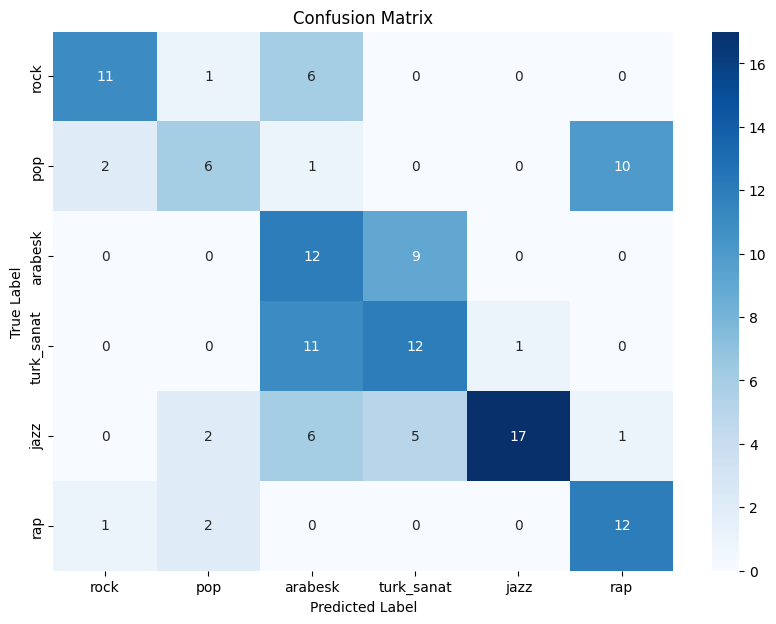

In [20]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predicted probabilities for each class
y_pred_probs = model.predict(X_test)

# Get predicted class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get true class labels (already one-hot encoded)
y_true_labels = np.argmax(y_test, axis=1)

# Generate and display a classification report
class_names = genre_names  # List of genre names
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Generate and display a confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()